In [ ]:
pip install -r requirements-inv.txt

In [1]:
# Import standard libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Import sklearn functions and classes
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve, validation_curve, KFold
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, make_scorer, explained_variance_score
)

# Import statsmodels for statistical tests
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

# Import XGBoost
from xgboost import XGBRegressor, plot_importance

# For defining parameter distributions
from scipy.stats import randint, uniform

# Suppress warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the cleaned DataFrame from the CSV file
df_pca_combined = pd.read_csv('df_pca_combined.csv')

# Utility Functions

In [3]:
# Utility functions
def prepare_data(df, target_column):  
    # Prepare data for machine learning
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def adjusted_r2_score(y_true, y_pred, X):
    n = len(y_true)
    p = X.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, X, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2_score(y_true, y_pred, X)
    
    metrics = {
        'Dataset': dataset_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2,
        'Adjusted R²': adj_r2,
        'Training Time': None  # Placeholder, will be updated in model scripts
    }
    return metrics

def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_validation_curve(model, X_train, y_train, param_name, param_range):
    train_scores, val_scores = validation_curve(model, X_train, y_train, param_name=param_name, param_range=param_range, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis=1)
    val_scores_mean = -val_scores.mean(axis=1)
    
    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', label="Training score")
    plt.plot(param_range, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(f"Validation Curve for {param_name}")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_pred, residuals)
    plt.hlines(0, xmin=y_pred.min(), xmax=y_pred.max(), linestyles='dashed')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.grid()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred):
    plt.figure()
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Prediction vs Actual")
    plt.grid()
    plt.show()

def save_results_to_csv(results, filename='model_results.csv'):
    df_results = pd.DataFrame(results)
    df_results.to_csv(filename, index=False)

def plot_metrics(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df.melt(id_vars='Dataset', value_vars=['RMSE', 'MAE', 'R²']), x='variable', y='value', hue='Dataset', ax=ax)
    ax.set_title('Model Performance Comparison', fontsize=20)
    ax.set_ylabel('Score', fontsize=15)
    ax.set_xlabel('Metrics', fontsize=15)
    ax.legend(title='Model', title_fontsize='13', fontsize='11')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def plot_timing(results):
    results_df = pd.DataFrame(results)
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.barplot(data=results_df, x='Dataset', y='Training Time', palette='viridis', ax=ax)
    ax.set_title('Model Training Time Comparison', fontsize=20)
    ax.set_ylabel('Time (seconds)', fontsize=15)
    ax.set_xlabel('Model', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

def error_analysis(y_true, predictions, model_name):
    error = y_true - predictions
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.histplot(error, bins=50, kde=True, color='coral', ax=ax)
    ax.set_title(f'Prediction Error Distribution for {model_name}', fontsize=20)
    ax.set_xlabel('Prediction Error', fontsize=15)
    ax.set_ylabel('Frequency', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    sns.despine()
    plt.show()

# XG Boost

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'Dataset': 'XGBoost (Training)', 'MSE': 0.004926347796247248, 'RMSE': 0.07018794623186554, 'MAE': 0.05148128263300438, 'MAPE': 26.753898433138897, 'R²': 0.9950359131647009, 'Adjusted R²': 0.994967642200555, 'Training Time': 6.868794679641724}
{'Dataset': 'XGBoost (Validation)', 'MSE': 0.019328043409823227, 'RMSE': 0.13902533369793876, 'MAE': 0.09645036631425316, 'MAPE': 44.609842293062414, 'R²': 0.9808084783343037, 'Adjusted R²': 0.9799938178227803, 'Training Time': None}
{'Dataset': 'XGBoost (Test)', 'MSE': 0.018053612142577818, 'RMSE': 0.13436373075565378, 'MAE': 0.09585189496826271, 'MAPE': 46.55072363690496, 'R²': 0.9823720171120435, 'Adjusted R²': 0.9816243375768283, 'Training Time': None}

Additional Metrics (Not Included in Inter-Model Comparison):
Cross-Validation RMSE: 0.1448728074634025
Cross-Validation MAE: 0.10131430881512142
Cross-Validation MAPE: 46.376034649803
Cross-Validation R²: 0.9788292716749183
Explaine

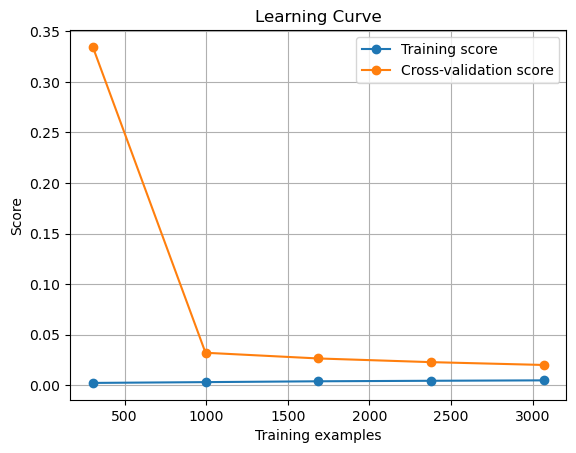

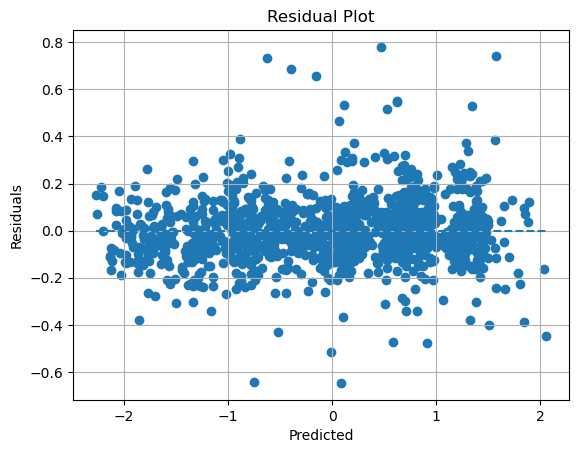

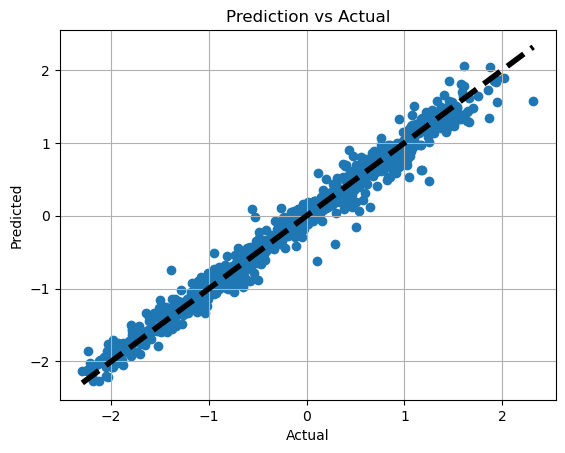

<Figure size 1200x800 with 0 Axes>

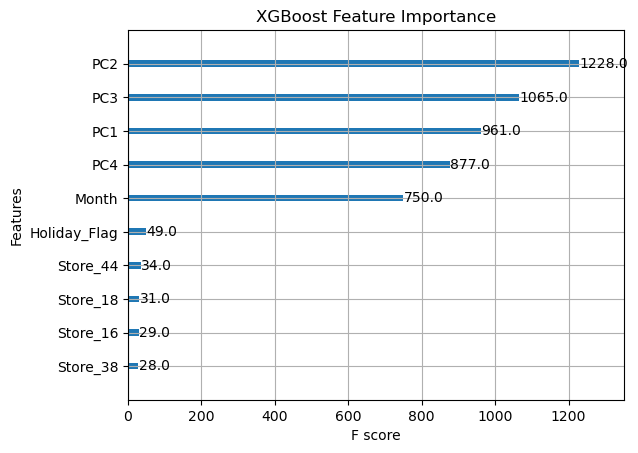

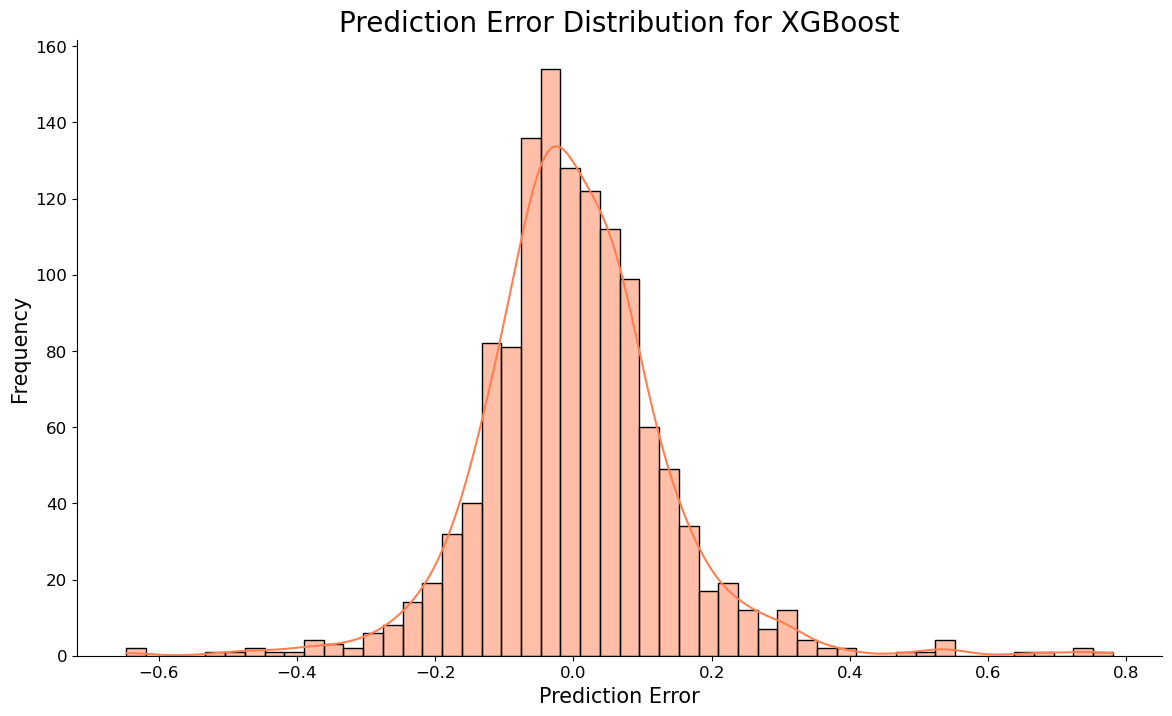

In [4]:
# Import necessary libraries for pre-inter-model comparison
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import explained_variance_score, make_scorer
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from xgboost import plot_importance

# Define the function to run the XGBoost model with separated metrics
def run_xgboost(df_pca_combined, target_column='Weekly_Sales', results_filename='xgboost_results.csv'):
    df_xgboost = df_pca_combined.copy()  # Create a copy of the dataframe
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(df_xgboost, target_column)

    # Define the model
    model = XGBRegressor(random_state=42)

    # Define hyperparameter distribution
    param_dist = {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 6),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

    # Random Search with Cross-Validation
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=50, 
        cv=5, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1, 
        random_state=42, 
        verbose=1
    )
    start_time = time.time()
    random_search.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Best model from random search
    best_model = random_search.best_estimator_

    # Predictions
    y_train_pred = best_model.predict(X_train)
    y_val_pred = best_model.predict(X_val)
    y_test_pred = best_model.predict(X_test)

    # Evaluate metrics (Inter-model comparison metrics)
    xgb_train_metrics = evaluate_model(y_train, y_train_pred, X_train, 'XGBoost (Training)')
    xgb_train_metrics['Training Time'] = training_time  # Update training time
    xgb_val_metrics = evaluate_model(y_val, y_val_pred, X_val, 'XGBoost (Validation)')
    xgb_test_metrics = evaluate_model(y_test, y_test_pred, X_test, 'XGBoost (Test)')

    # Perform cross-validation (k=5)
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    cv_mse_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_mse_scores.mean())
    cv_mae_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')
    cv_mae = -cv_mae_scores.mean()
    cv_mape_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False))
    cv_mape = -cv_mape_scores.mean()
    cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='r2')
    cv_r2 = cv_r2_scores.mean()

    # Explained Variance Score
    explained_var = explained_variance_score(y_test, y_test_pred)

    # Residual Analysis: Durbin-Watson Test for Autocorrelation
    residuals = y_test - y_test_pred
    dw_stat = durbin_watson(residuals)

    # Heteroscedasticity: Breusch-Pagan Test
    X_test_sm = sm.add_constant(X_test)
    _, bp_pval, _, _ = het_breuschpagan(residuals, X_test_sm)

    # Create results list only for inter-model comparison metrics
    results = [
        xgb_train_metrics,
        xgb_val_metrics,
        xgb_test_metrics
    ]

    # Save results to CSV for inter-model comparison
    save_results_to_csv(results, results_filename)

    # Print inter-model comparison results
    for result in results:
        print(result)

    # Print additional metrics separately (not included in results list)
    print("\nAdditional Metrics (Not Included in Inter-Model Comparison):")
    print(f"Cross-Validation RMSE: {cv_rmse}")
    print(f"Cross-Validation MAE: {cv_mae}")
    print(f"Cross-Validation MAPE: {cv_mape}")
    print(f"Cross-Validation R²: {cv_r2}")
    print(f"Explained Variance: {explained_var}")
    print(f"Durbin-Watson Stat: {dw_stat}")
    print(f"Breusch-Pagan p-value (Heteroscedasticity): {bp_pval}")

    # Plot learning curve
    plot_learning_curve(best_model, X_train, y_train)

    # Plot residuals
    plot_residuals(y_test, y_test_pred)

    # Plot predicted vs actual values
    plot_prediction_vs_actual(y_test, y_test_pred)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plot_importance(best_model, max_num_features=10)
    plt.title('XGBoost Feature Importance')
    plt.show()

    # Perform error analysis
    error_analysis(y_test, y_test_pred, 'XGBoost')

# Run the XGBoost model
run_xgboost(df_pca_combined)